# Match Plans - The Cold Start Problem

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Collection](#Data-Collection)
3. [Neural Network Explanation & Results](#Neural-Network-Explanation-&-Results)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Baseline Naive Model Building + Evaluation](#Baseline-Model-Building-&-Evaluation)
6. [Feature Engineering](#Feature-Engineering)
7. [Model Selection](#Model-Selection)
8. [Model Training](#Model-Training)
9. [Model Evaluation](#Model-Evaluation)
10. [Conclusion and Future Work](#Conclusion-and-Future-Work)
11. [References](#References)

## Introduction

#### *Problem Description*
In ROME (Renewal Optimization Engine), a fascet of the 'cold start problem' for small groups in california is that we receive a medical plan (characterized by plan_admin_name in the universal file type schema) and in order to complete current total cost, we must match those plans (via carrier name, plan name, network, issuer codes, and cost sharing details) to plans in the Ideon dataset available in the clients zip code. As of now, this manual matching process is a roadblock to potentially automating the configuration steps in ROME. A client may have anywhere from one plan to 12 plans, depending on the carrier/s and their decisions.

#### *Objective*
The objective of this project is to automate the matching process by developing a machine learning model that can accurately link a given medical plan name from a clients census to the correct plan in the ideon dataset. This is a data linkeage problem.

#### *Proposed Solution*
Levergaing the renewal workbooks already matched plans across clients, build a dataset that enables a machine learning algorithm to learn how to predict the correct ideon plan name given the census plan name. The target variable in this dataset will be a binary variable indicating a match (1 to represent positive) or not a match (0 to represent a negative).

#### import statements

In [1]:
# import statements
import os
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm
from google.cloud import bigquery
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from Levenshtein import distance as lev_distance
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from dotenv import load_dotenv

# Set options to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# setting environment variables
load_dotenv('/Users/kieranshaw/match-plans/.env')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Data Collection

* For each client that has gone through the workbook, we have already gotten their plans and then matched those plans with the plans from the Ideon dataset. This has been done manually.
* Because we have already matched, we can go through each workbook and collect that information. We've made a google sheet with this info and we can download it as an `actuals.csv`
* For each client, we want to go get all the available plans, create a dataframe, match only the matched plans in a dataset, and then keep doing that for all clients.
* After (or maybe during) we then need to create the false match case, where we still need to store all of the plans for a given client and then create a false match in the dataset.
* For each plan should we have every plan being a false match? How should we create the dataset?

In [8]:
# Reading in small group plans actuals to begin to build dataset
small_group_actuals_file_path = '~/match-plans/data/actuals.csv'
small_group_actuals_df = pd.read_csv(small_group_actuals_file_path)
small_group_actuals_df['plan_effective_start_date'] = pd.to_datetime(small_group_actuals_df['plan_effective_start_date'])
small_group_actuals_df.rename(columns={'plan_id':'id','carrier_name':'census_carrier_name'},inplace=True)

# prep the data to be able to query and iterate through
grouped = small_group_actuals_df.groupby(['client_name', 'zip_code', 'plan_effective_start_date'])

# Initialize list to store client objects
clients = []

# Loop through each group
for (client_name, zip_code, start_date), group in grouped:
    client = {}
    client['client_name'] = client_name
    client['zip_code'] = zip_code
    client['plan_effective_start_date'] = start_date

    # Extract year and quarter
    year = start_date.year
    quarter = (start_date.month - 1) // 3 + 1
    
    client['year'] = year
    client['quarter'] = f'Q{quarter}'
    client['plans'] = group.drop(columns=['client_name', 'zip_code', 'plan_effective_start_date']).to_dict(orient='records')
    clients.append(client)

# verify that we were able to get the information by printing 0th index
print(clients[0])

{'client_name': 'Aya Living', 'zip_code': 92108, 'plan_effective_start_date': Timestamp('2023-01-01 00:00:00'), 'year': 2023, 'quarter': 'Q1', 'plans': [{'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Sharp Gold HMO A', 'id': '92499CA0000003-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Bronze HMO B', 'id': '40513CA0000004-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Silver HMO A', 'id': '40513CA0000002-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Anthem Blue Cross Gold PPO E', 'id': '27603CA0000018-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Sharp Silver HMO B', 'id': '92499CA0000006-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Gold HMO B', 'id': '40513CA0000006-77'}]}


In [9]:
# BigQuery Client to Query Dataset
GOOGLE_APPLICATION_CREDENTIALS = '/Users/kieranshaw/.config/gcloud/application_default_credentials.json'

# initialize the client and saved dataframe
bq_client = bigquery.Client()
df = pd.DataFrame()
start_time = time.time()

for client in tqdm(clients, desc='Processing clients'):
    query_start_time = time.time()

    query = f"""
        WITH SelectedZip AS (
            SELECT * 
            FROM airbyte_ideon.zip_counties
            WHERE zip_code_id = '{client['zip_code']}'
            AND _ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
        )
        SELECT
            p.*
        FROM 
            SelectedZip zc
        JOIN 
            airbyte_ideon.plan_counties pc 
            ON zc.county_id = pc.county_id
            AND pc._ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
        JOIN 
            airbyte_ideon.plans p 
            ON p.id = pc.plan_id
            AND p._ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
    """
    
    # Run the query
    query_job = bq_client.query(query)

    # Fetch the results
    results = query_job.result()

    # Convert the results to a pandas DataFrame
    query_df = results.to_dataframe()

    # Create a DataFrame from the 'plans' key in the client object
    client_plans_df = pd.DataFrame(client['plans'])

    # Add columns for the client info
    client_plans_df['client_name'] = client['client_name']
    client_plans_df['zip_code'] = client['zip_code']
    client_plans_df['plan_effective_start_date'] = client['plan_effective_start_date']

    # Merge the results with the client info
    match_df = pd.merge(client_plans_df, query_df, on='id')
    match_df['is_match'] = 1

    # NON MATCHING PLANS FAKE DATA
    non_matching_plans = query_df[~query_df['id'].isin(client_plans_df['id'])]

    # Create a DataFrame for non-matching plans with client info
    non_matching_df = non_matching_plans.copy()
    non_matching_df['client_name'] = client['client_name']
    non_matching_df['zip_code'] = client['zip_code']
    non_matching_df['plan_effective_start_date'] = client['plan_effective_start_date']
    non_matching_df['is_match'] = 0  # Label as non-match
    non_matching_df['plan_admin_name'] = np.NaN
    non_matching_df['census_carrier_name'] = np.NaN

    # Add random plan_admin_name and carrier_name from the client's set
    client_plan_admin_names = set(client_plans_df['plan_admin_name'].dropna())
    client_carrier_names = set(client_plans_df['census_carrier_name'].dropna())
    non_matching_df['plan_admin_name'] = non_matching_df.apply(lambda row: random.choice(list(client_plan_admin_names)) if pd.isnull(row['plan_admin_name']) else row['plan_admin_name'], axis=1)
    non_matching_df['census_carrier_name'] = non_matching_df.apply(lambda row: random.choice(list(client_carrier_names)) if pd.isnull(row['census_carrier_name']) else row['census_carrier_name'], axis=1)

    final_df = pd.concat([match_df, non_matching_df], ignore_index=True)
    df = pd.concat([df, final_df], ignore_index=True)
    query_end_time = time.time()

end_time = time.time()
print(f"Processed {len(clients)} clients in {end_time - start_time:.2f} seconds")

Processing clients: 100%|██████████| 62/62 [03:17<00:00,  3.19s/it]

Processed 62 clients in 198.12 seconds


In [10]:
# reducing file size for only the columns that we want, so that we don't have everything in there (which is a lot of data) for no reason
columns = [
    "id",
    "name",
    "carrier_name",
    "plan_admin_name",
    "census_carrier_name",
    "plan_type",
    "level",
    "network_name",
    "issuer_plan_code",
    "hsa_eligible",
    "is_match"
]
df = df[columns].copy()

# save the dataframe of plans to data/small_group_dataset.csv
df.to_csv('~/match-plans/data/small_group_dataset.csv',index=False)

## Neural Network Explanation & Results

As part of the model selection work, I wanted to see if a neural network could be the right decision! After all, they have been known to be great with text.

To my dissapointment, a neural network did not perform super well right out of the gate. In a similar way to what I am planning on doing with RandomForest and XGBoost, I built an extremely naive neural network to see if it would perform decent on the task at hand. TLDR: it did not perform great. I think the crux of this issue is the following: a neural network is not optimized to perform extremely well out of the box. It requires more care and knowledge. It is not the "just throw a neural network at it and see what happens" type of answer. That is what XGBoost is (think, midwit meme format).

It is likely that after data cleaning and feature engineering that I might be able to stoke the flames of a neural network and get it performing well. But, that basically means we have reached diminishin returns using a boosting algo for classification / the boosting algo isn't getting us that performance we want and/or need.

I ran this neural network on google colab because my computer is borked. Anyway, here are the summary results...

**Accuracy: 99.39%**

|           | Precision | Recall | F1-score | Support |
|-----------|-----------|--------|----------|---------|
| Negative  | 1.00      | 1.00   | 1.00     | 12502   |
| Positive  | 0.35      | 0.27   | 0.31     | 63      |
|           |           |        |          |         |
| **Accuracy**  |           |        | 0.99     | 12565   |
| **Macro Avg** | 0.68      | 0.63   | 0.65     | 12565   |
| **Weighted Avg** | 0.99      | 0.99   | 0.99     | 12565   |

At first glance, one might go: "Oh dang, this has 99.5% accuracy out of the box!" Don't worry, I forgive you. I also said the same thing. Then, I looked under the hood a tiny bit. What we should be optimizing for in this problem space is the f1 score. You can find the explanation for that below when we get to model evaluation and what not. But, for short: we really, really, really care about false positive and false negatives... we want to be precise! see ChatGPT: "The F1 score is especially relevant in scenarios where false positives and false negatives have a significant cost or when dealing with imbalanced datasets where positives are much fewer than negatives." On the other side of the coin, accuracy is, well, just that: "the proportion of correct predictions (both true positives and true negatives) out of all predictions. It's the total number of correct classifications divided by the total number of classifications." I will let you in on a little secret that we will get to later - the accuracy is so dang high because of the proportion of negatives:positives in the set. In other words, accuracy is masking the fact that we aren't doing great on the predicting the positive class.

As mentioned, applying weights didn't really help. If anything, it got worse on some important dimensions.

**Accuracy: 96.59%**

|            | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Negative   | 1.00      | .97   | 0.98     | 12502   |
| Positive   | 0.08      | 0.56   | 0.14     | 63      |
| **accuracy** |           |        | 0.97    | 12565   |
| **macro avg**  | 0.54      | 0.76   | 0.59     | 12565   |
| **weighted avg** | 0.99      | 0.97   | 0.98     | 12565   |

**why our neural network doesn't work well out of the box**

Now we are back to explaining the metrics. Well, our model was pretty dang good at learning all the negative targets, but pretty poor at learning the positives. Given that we care about the positives, well, this doens't bode well. For that reason, I'm putting those model to the side until we do some more serious feature engineering. Even then, I'm not sure it would be great. Even if I messed around with the predicted probability and brought it all the way down from > 0.5 (which means the model predicts the positive class) to 0.2, our overall numbers got worse and our f1 did not improve. Quite telling that this is just a poor model.

Confusion matrix

<img src="plots/naive_nn_confusion_matrix_plot.png" alt="Neural Network Confusion Matrix" width="400"/>

## Exploratory Data Analysis

Some things that stand out to me, that we should check out in the dataset just so we know before running any other naive models.

There are a few things that I want to look at in this dataset:
* target class imbalance
* feature engineering
    * what strings do we see and how often? matches vs. non-matches?
    * how can we think about string similarity across matches and non matches? if the match strings are similar, then we should be able to do well
    * any common ends of strings? beginning of strings?
    * string length - is it variable between matches and non matches?

---
WAIT, just had an idea: a big part of feature engineering for this dataset is likely going to be intelligently decomposing the string that we get from the census...
* wow, I can't believe I did not think of this earlier
* I should be using an LLM function call for specific components to decompose the string and then I can use that decomposed string to build a dataset of features.
* In other words, if the HARD problem of making this more accurate is correctly decomposing the plan admin name into relevant features (ex: what type of plan is it? what is the metallic level of the plan? is the plan HDHP eligible or not? Is there an appendage on the plan like HMO B or CQXY or 6RJ8?)
    * plan_type
    * is_hdhp
    * metallic_level
    * plan_name
    * full_name
    * appendage
    * network_name
* the key thing here is to stuff the prompt with examples of what we want to see. So, if we give it some varied examples from each carrier that we see in the census, then we could except better accuracy.

What is the problem with this?
* well, our feature engineering depends on an LLM because of hallucination, incorrect parsing, etc.
* I think the tradeoff may be worth it, especially if it does such a good job as we want on parsing this unstructed data and giving us structured data in return to deal with

**Target Class Frequency Plot**

<img src="plots/target_class_frequency_plot.png" alt="Target Class Frequency" width="400"/>

*Analysis*
* Point is clear: this is an imbalanced dataset. When we create the dataset, we query the database to find every available plan and then join the known plans (by plan_id) onto the dataset with all available plans. We do this for each client. What this results in as an average of 1 matched plan per 332 non matched plans (1:332) or .5% of matches.
* Balacing this dataset will be crucial when building the models.

**Word Cloud Plot**

<img src="plots/word_cloud_plot.png" alt="Target Class Frequency" width="400"/>

*Analysis*
* What we see in this word cloud plot is that we have a decent amount of carrier strings in the `plan_admin_name, a large number of the metallic level of the plan, and the plan type.
* What we don't see is the `network`, which is something that is crucial to matching the correct plan. We will need to build a mapping / understanding some examples if we want to feature engineer there.

**Census Carrier + Census Plan Admin Name Word Frequency Plot**

<img src="plots/census_word_frequency_plot.png" alt="Census Word Frequency" width="400"/>

*Analysis*
* This is not super suprising, and we see a similar story as to the word count. We have a lot of plan metallic level, plan type strings, and some networks snuck in there (along with carriers).

**Levenshtein Distance for Matched and Non Matched Strings**

<img src="plots/string_distance_distribution_plot.png" alt="Matched & Non Matched String Distance" width="400"/>

*Analysis*
* This is a really interesting plot. Please take note of the different X and Y axis. The X axis is slightly different, and it doesn't make sense to normalize the Y axis.
* Fascinating that we have a normal distribution for the non-matched data. With string distance we might expect it to be skewed one way or another (right or left). But, I think that the Central Limit Theorem is at play. This theorem states that when independent random variables are added, their properly normalized sum tends toward a normal distribution, even when the original variables themselves are not normally distributed. Basically, although the plan names themselves aren't normally distributed, the distance vs. plans are normally distributed, where we have some that are close (which our model will need to be careful of) and some that are far away (which will be easy to predict). This information can inform us that we should exepct some specific differences, espeically for the average distance.
* The matched distribution is a little more expected and standard. Basically, we see that we have a bunch that are REALLY dang close, or a high frequency of little distance.
* We should anticipate a large number of pairs to have a very small edit distance, signifying that there are only minor differences between the strings. This is probably a bit muddied by the lack of string cleaning, but it is interesting to note that it still kind of holds true. As we do some basic string cleaning, we should expect this chart to get better; which means that we should have a stronger skew right or positively skewed.
* We kind of have a secondary peak here at around 15-35 of distance. This means that there are a decent number of plans that are kind of close, but could vary by some standard combination of words, which a string cleaning exercise could help with.
* We definitly have a long tail and we do have some outliers, and that is to be expected.

In [58]:
proportion_of_matches = (df["is_match"].sum() / len(df)) * 100
print("Proportion of matches: "+str(proportion_of_matches))
counts = Counter(df['is_match'])
print("Ratio of positive:negative target class: 1:"+str(counts[1]))

Proportion of matches: 0.5284856974578565
Ratio of positive:negative target class: 1:332


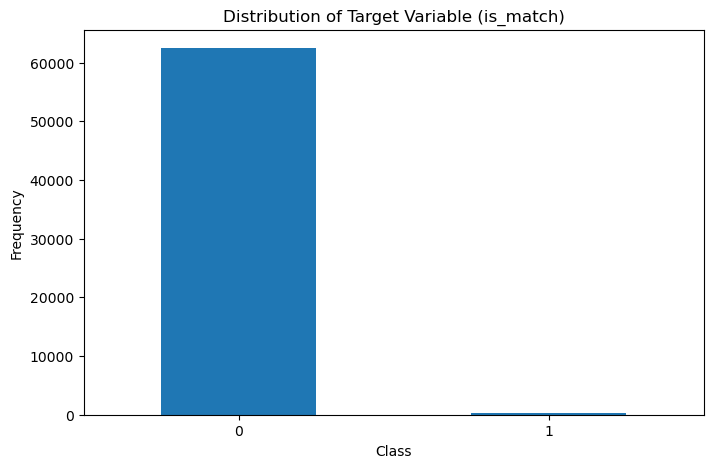

In [42]:
# plotting the distribution of the target
is_match_counts = df['is_match'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
is_match_counts.plot(kind='bar')
plt.title('Distribution of Target Variable (is_match)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


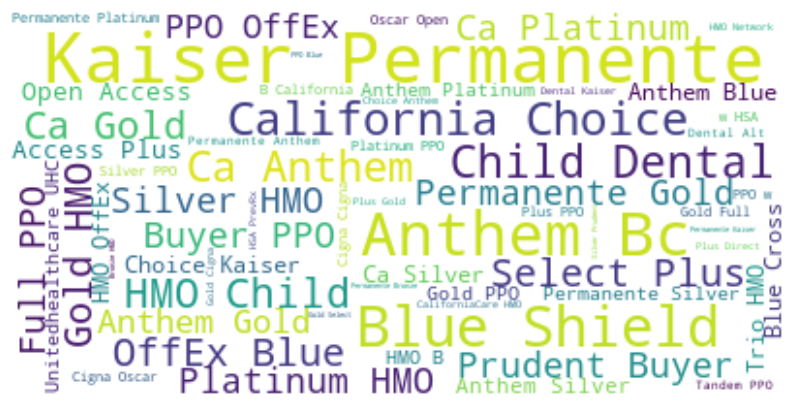

In [11]:
# Word clouds (or tag clouds) visually represent the frequency of words. The size of each word in the word cloud indicates its frequency or importance in the dataset.

# Combine all text into one large string for the census information. we don't really care about the ideon information because we know what that will be
all_text = ' '.join(df[["census_carrier_name","plan_admin_name"]].astype(str).agg(' '.join, axis=1))

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.show()

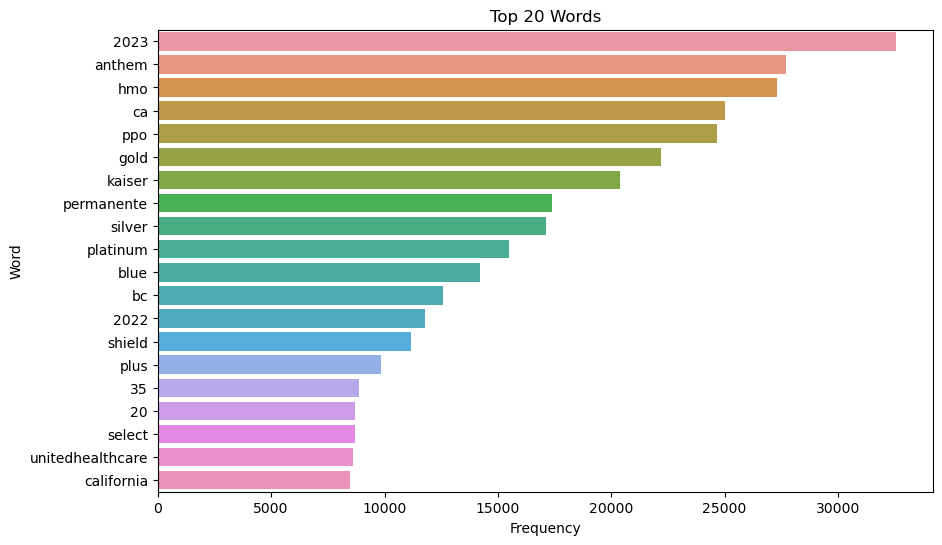

In [14]:
# Bar charts or histograms can be used to display the frequency of the top N words or terms in the dataset.

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text
text_documents = df[["census_carrier_name", "plan_admin_name"]].astype(str).agg(' '.join, axis=1).tolist()
X = vectorizer.fit_transform(text_documents)

# Sum word occurrences
word_counts = np.sum(X.toarray(), axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))

# Convert to DataFrame for easy plotting
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top 20 words
top_words = word_freq_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_words)
plt.title('Top 20 Words')
plt.show()

/Users/kieranshaw/match-plans/.conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kieranshaw/match-plans/.conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


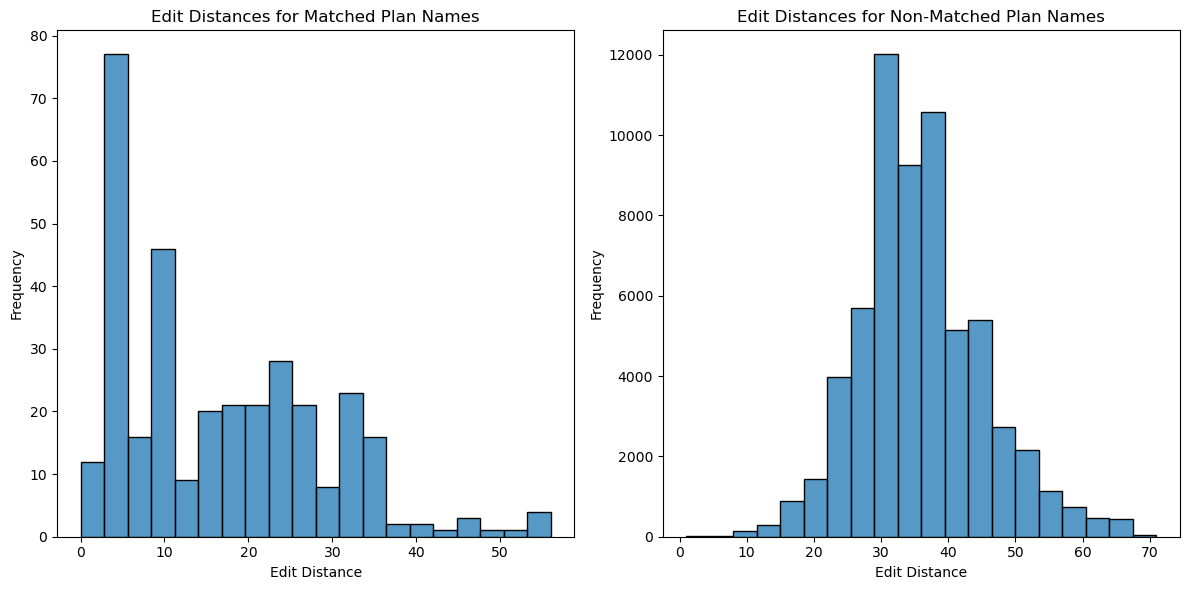

In [35]:
# what is the distance between matched plan names?
matched_names = df[df["is_match"] == 1][["plan_admin_name", "name"]]
non_matched_names = df[df["is_match"] == 0][["plan_admin_name", "name"]]

# Calculate edit distances for matched pairs
edit_distances_matched = [lev_distance(p1, p2) for p1, p2 in zip(matched_names["plan_admin_name"], matched_names["name"])]

# Calculate edit distances for non-matched pairs
edit_distances_non_matched = [lev_distance(p1, p2) for p1, p2 in zip(non_matched_names["plan_admin_name"], non_matched_names["name"])]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for matched pairs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(edit_distances_matched, bins=20, kde=False)
plt.title('Edit Distances for Matched Plan Names')
plt.xlabel('Edit Distance')
plt.ylabel('Frequency')

# Plot for non-matched pairs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(edit_distances_non_matched, bins=20, kde=False)
plt.title('Edit Distances for Non-Matched Plan Names')
plt.xlabel('Edit Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Baseline Model Building & Evaluation

One of this first steps in establishing a baseline is deploying a naive model, or set of models. The baseline will enable us to say a) if a model is better or worse and b) on what dimensions the performance differs. Basically, we are going to set a benchmark against which we can compare.
* Benchmark - a comparison against future models
* Simplicity - a super simple model is easy to interpret and understand

* We will take the 4 columns that we use to match on in the UI and to train a model on those.
  * `census_carrier_name`
  * `plan_admin_name`
  * `carrier_name`
  * `name`

In [3]:
# helpful functions, metrics_df
def calculate_metrics(model, X_test, y_test, metrics_df: pd.DataFrame, model_name: str, save_metrics: bool = True):
    predictions = model.predict(X_test)
    prob_predictions = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc_score = roc_auc_score(y_test, prob_predictions) if prob_predictions is not None else "N/A"
    conf_matrix = confusion_matrix(y_test, predictions)

    # Define the metrics for this model
    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "F1 Score": f1_score(y_test, predictions),
        "ROC-AUC": auc_score,
        "Confusion Matrix": conf_matrix
    }
    
    # Add a new row to the DataFrame with the new metrics
    metrics_df.loc[model_name] = metrics

    # saving metrics
    if save_metrics:
        directory = "~/match-plans/notebooks/results"
        directory = os.path.expanduser(directory)
        if not os.path.exists(directory):
            os.makedirs(directory)
        full_path = f"{directory}/metrics.csv"
        metrics_df.to_csv(full_path)

    return metrics_df

def plot_roc_auc(model, X_test, y_test, plot_name: str = None):
    # Predict probabilities for the positive outcome only
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    # Calculate ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Plot')
    plt.legend(loc="lower right")

    # saving figure
    if plot_name:
        directory = "~/match-plans/notebooks/plots"
        directory = os.path.expanduser(directory)
        if not os.path.exists(directory):
            os.makedirs(directory)
        full_path = f"{directory}/{plot_name}.png"
        plt.savefig(full_path)
    
    plt.show()
    plt.close()
    
    return roc_auc

metrics_df_columns = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Confusion Matrix"]

# create an empty DataFrame with these columns
metrics_df = pd.DataFrame(columns=metrics_df_columns)

In [2]:
# if there is no df
df = pd.read_csv('/Users/kieranshaw/match-plans/data/small_group_dataset.csv')

# pre-process the data by creating a new df with those columns
df_naive = df[['census_carrier_name', 'plan_admin_name', 'carrier_name', 'name']].copy()

# Combine the text columns into one, as we will treat them as one input to the network
df_naive['combined_text'] = df_naive.apply(lambda x: ' '.join(x.astype(str)), axis=1)

# 'is_match' is the binary target column we want to predict
y = df['is_match'].values

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the combined text column to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df_naive['combined_text'])

# Split the TF-IDF vectors and the target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#### Random Forest Classifier, Baseline Model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight=None, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.377 total time=  10.8s
[CV 2/5] END class_weight=None, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.378 total time=  12.4s
[CV 3/5] END class_weight=None, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.395 total time=  12.1s
[CV 4/5] END class_weight=None, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.453 total time=  11.1s
[CV 5/5] END class_weight=None, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.429 total time=  12.4s


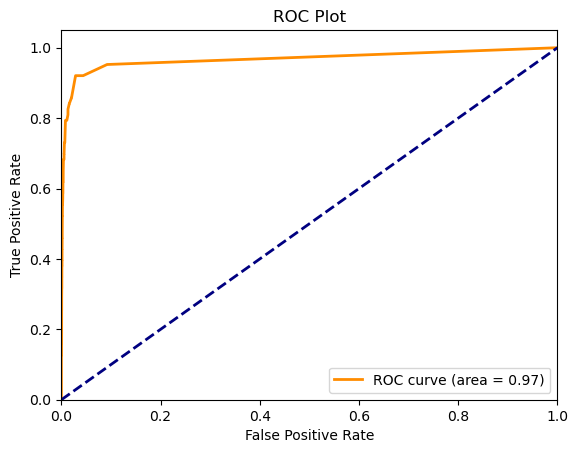

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Confusion Matrix
Baseline Random Forest,0.995862,0.72,0.285714,0.409091,0.967735,"[[12495, 7], [45, 18]]"


In [23]:
# Set up the parameter grid to search
rf_parameter_grid = {
    "n_estimators": [100], # standard value
    "max_depth": [None],
    "max_features": ["sqrt"], # sqrt is the standard
    "max_leaf_nodes": [None],
    "class_weight": [None],
    "min_samples_split": [2], # standard value
    "min_samples_leaf": [1] # standard value
}

# Set up the grid search with RandomForest
grid_search_rf_model = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                    param_grid=rf_parameter_grid,
                                    scoring='f1',
                                    cv=5,
                                    verbose=3)

# Perform the search on the training data
grid_search_rf_model.fit(X_train, y_train)

# Get the best estimator model
best_rf_model = grid_search_rf_model.best_estimator_

# add metrics to metrics_df
metrics_df = calculate_metrics(best_rf_model, X_test, y_test, metrics_df=metrics_df, model_name="Baseline Random Forest")

# plot and print df
rf_auc = plot_roc_auc(best_rf_model, X_test, y_test, plot_name='baseline_random_forest_roc')
metrics_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=None, max_depth=None, min_child_weight=None, n_estimators=None, scale_pos_weight=None, subsample=None;, score=0.681 total time=   1.1s
[CV 2/5] END learning_rate=None, max_depth=None, min_child_weight=None, n_estimators=None, scale_pos_weight=None, subsample=None;, score=0.635 total time=   1.0s
[CV 3/5] END learning_rate=None, max_depth=None, min_child_weight=None, n_estimators=None, scale_pos_weight=None, subsample=None;, score=0.737 total time=   1.0s
[CV 4/5] END learning_rate=None, max_depth=None, min_child_weight=None, n_estimators=None, scale_pos_weight=None, subsample=None;, score=0.660 total time=   1.0s
[CV 5/5] END learning_rate=None, max_depth=None, min_child_weight=None, n_estimators=None, scale_pos_weight=None, subsample=None;, score=0.747 total time=   1.0s


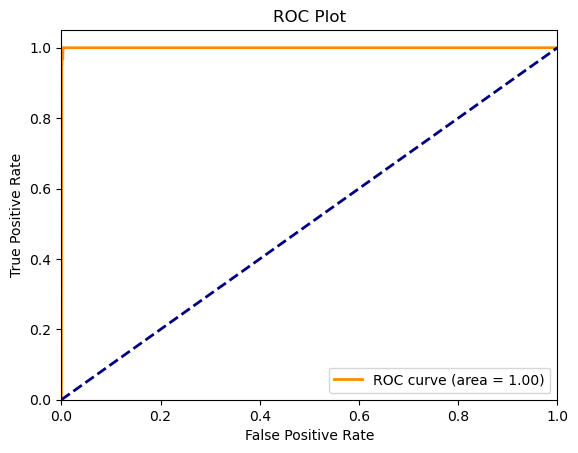

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Confusion Matrix
Baseline XGBoost,0.998647,0.896552,0.825397,0.859504,0.999624,"[[12496, 6], [11, 52]]"


In [4]:
# XGBOOST
xgb_parameter_grid = {
    "max_depth": [None],
    "learning_rate": [None],
    "n_estimators": [None],
    "min_child_weight": [None],
    "subsample": [None],
    "scale_pos_weight": [None]
}

# Set up the grid search with RandomForest
grid_search_xgb_model = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                    param_grid=xgb_parameter_grid,
                                    scoring='f1',
                                    cv=5,
                                    verbose=3)

# Perform the search on the training data
grid_search_xgb_model.fit(X_train, y_train)

# Get the best estimator model
best_xgb_model = grid_search_xgb_model.best_estimator_

# add metrics to metrics_df
metrics_df = calculate_metrics(best_xgb_model, X_test, y_test, metrics_df=metrics_df, model_name="Baseline XGBoost")

# plot and print df
rf_auc = plot_roc_auc(best_xgb_model, X_test, y_test, plot_name='baseline_xgboost_roc')
metrics_df

In [9]:
# naive model saving to endpoint
import joblib
vectorizer_path = '/Users/kieranshaw/match-plans/deploy/utils/vectorizer.joblib'
model_path = '/Users/kieranshaw/match-plans/deploy/utils/model.joblib'
joblib.dump(tfidf_vectorizer, vectorizer_path)
joblib.dump(best_xgb_model, model_path)

sample = {
    "target": {
        "name": "sample",
        "carrier": "sample"
    },
    "plans": [
        {
            "id": "sample",
            "name": "sample",
            "carrier": "sample"
        },
                {
            "id": "sample",
            "name": "sample",
            "carrier": "sample"
        }
    ]
}

['/Users/kieranshaw/match-plans/deploy/utils/model.joblib']

#### metrics df result & explanation

| Model                | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Confusion Matrix       |
|----------------------|----------|-----------|---------|----------|----------|------------------------|
| Baseline Random Forest | 0.995862 | 0.720000  | 0.285714| 0.409091 | 0.967735 | [[12495, 7], [45, 18]] |
| Baseline XGBoost     | 0.998647 | 0.896552  | 0.825397| 0.859504 | 0.999624 | [[12496, 6], [11, 52]] |

[Link to CSV file](results/metrics.csv)

#### metrics definitions (s/o gpt4)
* Accuracy
    * This tells us the percentage of total predictions that were correct. It's a good overall measure of how often the model is right, but it might not give the full picture, especially if the data is imbalanced (when one class is much more frequent than others).

* Precision
    * Precision tells us the proportion of positive identifications that were actually correct. For example, if the model predicts an email as spam (positive), precision tells us how many of those were actually spam.

* Recall
    * Recall tells us the proportion of actual positives that were correctly identified. Continuing with the spam example, recall would measure how many of the actual spam emails were correctly identified by the model.

* **F1 Score**
    * The F1 score combines precision and recall into a single metric by taking their harmonic mean. It gives a better measure of the incorrectly classified cases than the Accuracy Metric, especially if the class distribution is imbalanced. It's a way to make sure that both our precision and recall are taken into account, balancing the two.

* ROC-AUC
    * This stands for Receiver Operating Characteristic - Area Under Curve. It's a measure of a model's diagnostic ability, which tells us how well the model can distinguish between classes. A score of 1 means the model makes perfect predictions, while a score of 0.5 means it's doing no better than random guessing.

* Confusion Matrix
    * This is a table that shows the actual values versus the model's predictions. It helps us see when the model is getting things right and when it's making mistakes. 
    * For instance, in the Random Forest model, [[12495, 7], [45, 18]] means:
        * 12495 true negatives: the model correctly predicted the negative class
        * 7 false positives: the model incorrectly predicted the positive class
        * 45 false negatives: the model incorrectly predicted the negative class
        * 18 true positives: the model correctly predicted the positive class

#### understanding the results

* well, folks, it looks like our XGBoost model just does pretty dang well right off the bat.
* This is honestly pretty exciting, and it really matches with the magic of the XGBoost models that has kind of become a meme out there.
* the baseline random forest model has a high accuracy (nearly 99.6%), but its recall and F1 score are relatively low, indicating it struggles to identify all the positive cases correctly, which is a problem for us.
* the baseline XGBoost model, on the other hand, shows improvements across all metrics compared to the random forest model, especially in precision, recall, and F1 score. This suggests it's not only good at making correct predictions overall (as shown by its high accuracy) but also particularly effective at identifying positive cases without making many mistakes (high precision and recall).

#### next steps

What are some next steps?
1. I want to first try some re-sampling. In other words, I want to run these models again but with trying to solve the class imbalance.
2. After that, I think I want to try a different vectorizer besides TFDIF. There are probably some better out there, and could be worth an exploration.
2. After seeing what the results of those things are, I think the next place to go is feature engineering. Let's engineer some features for each of the models and see what happens.
3. After that, I think we will have a really good idea of which model will work for us, and then we can go more down the feature engineering path + potentially thinking about hyperparameters.


I would be remiss if I didn't talk about another way to solve this problem. Because we might not get predictable and cleaned data each time, we COULD use an LLM to help us solve the last mile. In other words, if we could return the top 5 most likely plans based on an initial model and then have an LLM - which is great at the non-structured stuff - try and get that last mile of accuracy for us, that could work. The question is... how do we know when to fire off the API request to the LLM. I guess we could have some probability metric where if below a threshold we fire it off? Maybe the context window is just so small that it doesn't even matter from a cost perspective and we could use gpt-3-turbo. I don't really know... but, this is an angle to play with.



## Feature Engineering

some high level goals of feature engineering, what it is, and why we care about it

what is it?
* feature engineering is both an art and a science. it requires domain / problem space knowledge, some creativity, and analytical thinking to enhance our dataset's ability to highlight underlying patterns and relationships relevant to this prediction task

why?
* well, we want to improve our model's predictive power!
* by creating new features or transforming existing ones, we can uncover and represent deeper insights from the data. These relationships might not be readily available / apparent with the raw data. 
* some well built features can help models capture the nuances of the data, leading to better understanding and prediction of the target variable... think: network strings or HMO B vs. CQYC as part of the plan strings

what do we plan to do?
* basically, my approach is as follows:
    1. extract features from the `plan_admin_name` that can help predict the ideon information (use an LLM maybe for this)
        * because each census plan admin name is created by a human, this data can be (and is) extremely unstructured. in other words, we don't know how, what parts of a plan name, what order, or really much about HOW a CM / BA / GA / HR team might input this information into a benefits administration / HRIS system
        * as a result, we shouldn't *assume* any patterns with rigid rules, we should search for things if they exist and then create features if they are there
        * this means that we might have null values... which XGBoost can handle!
    2. we should then relate these textual features using vectors, string length, cosine similarity, and levenshtein distance to give our model the ability to learn relationships between ANY set of metrics


#### Working with LLMs
* this was more frustrating than I wanted it to be, to be honest

In [80]:
# using LlamaIndex
from pydantic import BaseModel, Field
from typing import List
from llama_index.llms.openai import OpenAI
from llama_index.program.openai import OpenAIPydanticProgram
from llama_index.core import ChatPromptTemplate as LlamaIndexChatPromptTemplate
from llama_index.core.llms import ChatMessage

class NormalizedMedicalPlan(BaseModel):
    """Data model for sturctured medical plan features."""
    cleaned_plan_name: str = Field(
        description="From the provided plan name, please clean the unnecessary aspects which will not help identify the plan name. For example, remove year values or client names or any other unnecessary pieces."
    )
    metallic_level: str = Field(
        description="The metallic level extracted from the provided medical plan name."
    )
    plan_type: str = Field(description="The extracted plan type from the medical plan. One of PPO, HMO, EPO, or POS, if avilable.")
    is_hdhp: bool = Field(description="Is the provided medical plan a high deductible health plan (HDHP) or not? If the plan is a HDHP, the provided medical plan might contain 'HDHP' or 'HSA' in the provided medical plan name. Sometimes, 'savings' may be in the provided plan name, and that indicates that the plan is a HDHP.")
    network_name: str = Field(description="If the name of the network is in the plan name, please extract it. A carrier name is not a network name.")
    plan_appendage: str = Field(description="If there is an appendage at the end of the provided medical plan name, please extract it. Examples are items that look like 'HMO A', '6RGW', 'CP-SY'. A plan appendage for some plans could look like 'HMO A' or 'HMO B'. A plan appendage is not cost sharing details like 500/35 or 500/20/30%. If there is not a clear appendage similar to the examples, do not return one.")


# using an LLM to extract structured plan details with the llamaindex work

llm = OpenAI(model="gpt-3.5-turbo-1106")

prompt = LlamaIndexChatPromptTemplate(
    message_templates=[
        ChatMessage(
            role="system",
            content=(
                "You are an expert assistant for extracting structured features from a provided medical plan name string."
            ),
        ),
        ChatMessage(
            role="user",
            content=(
                "Here is the medical plan: \n"
                "------\n"
                "{sample_medical_plan}\n"
                "------"
            ),
        ),
    ]
)

program = OpenAIPydanticProgram.from_defaults(
    output_cls=NormalizedMedicalPlan,
    llm=llm,
    prompt=prompt,
    verbose=False,
)

sample_medical_plan = df["plan_admin_name"].unique()[64]

output = program(sample_medical_plan=sample_medical_plan)

output.model_dump()

In [160]:
from langchain_community.utils.openai_functions import (
    convert_pydantic_to_openai_function,
)
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, FewShotChatMessagePromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

# using langchain
# generating examples to stuff in the prompt for few-shot prompting, examples should focus on extracting an appendage (HMO A, 6XQY, etc.), HDHP, and probably network name

class NormalizedMedicalPlan(BaseModel):
    """Data model for sturctured medical plan features."""
    cleaned_plan_name: str = Field(
        description="From the provided plan name, please clean the unnecessary aspects which will not help identify the plan name. For example, remove year values or client names or strings like Base Plan. Please keep the metallic level in the cleaned plan name, these are crucial pieces of information."
    )
    metallic_level: str = Field(
        description="The metallic level extracted from the provided medical plan name."
    )
    plan_type: str = Field(description="The extracted plan type from the medical plan. Valid values are PPO, HMO, EPO, or POS.")
    is_hdhp: bool = Field(description="Is the provided medical plan a high deductible health plan (HDHP) or not? If the plan is a HDHP, the provided medical plan might contain 'HDHP' or 'HSA' in the provided medical plan name. Sometimes, 'savings' may be in the provided plan name, and that indicates that the plan is a HDHP.")
    plan_appendage: str = Field(description="If there is an appendage at the end of the provided medical plan name, please extract it. Valid appendages are strings that look like 'HMO A', '6RGW', 'CP-SY'. A plan appendage for some plans could look like 'HMO A' or 'HMO B', so please return the entire plan appendage in the example 'HOM A'. A plan appendage is not cost sharing details like 500/35 or 500/20/30%, or something like OffEx. If there is not a clear appendage similar to the examples, do not return one. Alt is not a valid plan appendage.")

openai_functions = [convert_pydantic_to_openai_function(NormalizedMedicalPlan)]

model = ChatOpenAI(temperature=0,model="gpt-4")

# examples = [
#     {
#         "input": "!2023 Platinum Harmony 25-50/400d CW-X2",
#         "output": {
#             "cleaned_plan_name": "Platinum Harmony 25-50/400d CW-X2",
#             "metallic_level": "Platinum",
#             "plan_type": "",
#             "is_hdhp": False,
#             "network_name": "Harmony",
#             "plan_appendage": "CW-X2",
#         }
#     },
#     {
#         "input": "2022 Silver Select Plus 55/1950/40% CP-AJ",
#         "output": {
#             "cleaned_plan_name": "Silver Select Plus 55/1950/40% CP-AJ",
#             "metallic_level": "Silver",
#             "plan_type": "PPO",
#             "is_hdhp": False,
#             "network_name": "Select Plus",
#             "plan_appendage": "CP-AJ",
#         }
#     },
#     {
#         "input": "M) 22-23 Anthem Prudent Buyer Bronze HSA PPO A",
#         "output": {
#             "cleaned_plan_name": "Anthem Prudent Buyer Bronze HSA PPO A",
#             "metallic_level": "Bronze",
#             "plan_type": "PPO",
#             "is_hdhp": False,
#             "network_name": "Prudent Buyer",
#             "plan_appendage": "PPO A",
#         }
#     },
#     {
#         "input": "2023 Anthem Bronze Prudent Buyer PPO 6700/0% w/HSA PrevRx 6RG7",
#         "output": {
#             "cleaned_plan_name": "Anthem Bronze Prudent Buyer PPO 6700/0% w/HSA PrevRx 6RG7",
#             "metallic_level": "Bronze",
#             "plan_type": "PPO",
#             "is_hdhp": True,
#             "network_name": "Prudent Buyer",
#             "plan_appendage": "6RG7",
#         }
#     },
#     {
#         "input": "2023 OA Managed Choice POS Gold CA 75/50 500",
#         "output": {
#             "cleaned_plan_name": "OA Managed Choice POS Gold 75/50 500",
#             "metallic_level": "Gold",
#             "plan_type": "POS",
#             "is_hdhp": False,
#             "network_name": "Managed Choice",
#             "plan_appendage": "",
#         }
#     },
#     {
#         "input": "Silver Full PPO Savings 2300",
#         "output": {
#             "cleaned_plan_name": "Silver Full PPO Savings 2300",
#             "metallic_level": "Silver",
#             "plan_type": "PPO",
#             "is_hdhp": True,
#             "network_name": "",
#             "plan_appendage": "",
#         }
#     },
#     {
#         "input": "2023 Gold Full PPO 750/30 OffEx",
#         "output": {
#             "cleaned_plan_name": "Gold Full PPO 750/30 OffEx",
#             "metallic_level": "Gold",
#             "plan_type": "PPO",
#             "is_hdhp": False,
#             "network_name": "Full",
#             "plan_appendage": "",
#         }
#     }
# ]

# example_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("human", "{input}"),
#         ("system", "{output}"),
#     ]
# )

# few_shot_prompt = FewShotChatMessagePromptTemplate(
#     example_prompt=example_prompt,
#     examples=examples,
# )

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert assistant for extracting structured features from a provided medical plan name string. You must use the function and return valid JSON."),
        ("human", "here is the medical plan name: {input}")]
)
print(prompt)
parser = JsonOutputFunctionsParser()

chain = prompt | model.bind(functions=openai_functions) | parser

sample_medical_plan = df["plan_admin_name"].unique()[120]
print(sample_medical_plan)

response = chain.invoke({"input": f"{sample_medical_plan}"})
response

input_variables=['input'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are an expert assistant for extracting structured features from a provided medical plan name string. You must use the function and return valid JSON.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='here is the medical plan name: {input}'))]
2023 Kaiser Permanente Bronze HMO C HSA


{'cleaned_plan_name': 'Kaiser Permanente Bronze HMO C',
 'metallic_level': 'Bronze',
 'plan_type': 'HMO',
 'is_hdhp': True,
 'plan_appendage': 'C'}

#### Cleaning with Regex

In [ ]:
# what co

In [ ]:
best_xgb_model

## EXTRA STUFF PROBLEM 1: OVERSAMPLING

1. First, let's actually plot / prove that we have an oversampling problem. Let's check out the dataframes and get a plot going.
2. Then, we will try to remedy and re-run the XGBoost model.

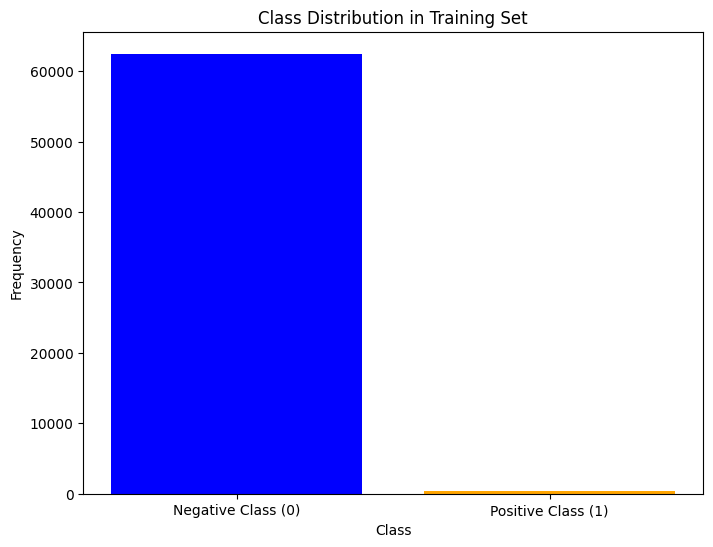

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each class in the target variable
class_counts = np.bincount(y_train)
class_labels = ['Negative Class (0)', 'Positive Class (1)']

# Plotting the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.show()


In [ ]:
from collections import Counter

# Assuming y is the target variable array from your dataset
counter = Counter(y_train)

# Estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print(f'Estimate: {estimate:.3f}')

Estimate: 185.825


What is the takeaway here?

* basically, we have a massively imbalance dataset. For every one positive target, we have ~185 negative targets. What that means is that the model is going to learn the negative targets really really well, and we need to get it to learn the positive targets better.

What are some solutions?
1. We can just use that estimate from the y_train as the weight.
2. We can use some GridSearch to tune this hyperparameter?

In [ ]:
# 1. we use that estimate variable
xgb_model_balanced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=estimate)
xgb_model_balanced.fit(X_train, y_train)

# let's see the metrics!
xgb_metrics_estimate = calculate_metrics(xgb_model_balanced, X_test, y_test)
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, xgb_metrics_estimate], index=["Random Forest", "XGBoost", "XGBoost, Estimate Balanced"])
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Support (Negative),Support (Positive)
Random Forest,0.995782,0.692308,0.285714,0.404494,0.984658,12502,63
XGBoost,0.997294,0.723077,0.746032,0.734375,0.999064,12502,63
"XGBoost, Estimate Balanced",0.997214,0.645833,0.984127,0.779874,0.999312,12502,63


That is sweet! Look at the improvement in the f1 socre. Our Accuruact wen't down slightly and we see that reflected in the precision. BUT, our f1 score increased.

| Model                     | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Support (Negative) | Support (Positive) |
|---------------------------|----------|-----------|---------|----------|----------|--------------------|--------------------|
| Random Forest             | 0.995782 | 0.692308  | 0.285714| 0.404494 | 0.984658 | 12502              | 63                 |
| XGBoost                   | 0.997294 | 0.723077  | 0.746032| 0.734375 | 0.999064 | 12502              | 63                 |
| XGBoost, Estimate Balanced| 0.997214 | 0.645833  | 0.984127| 0.779874 | 0.999312 | 12502              | 63                 |


In [30]:
# For the first weight, lets go from 1 to 300 in steps of 50. Then we can narrow.
# first pass - we got 51 as the best value - list(range(1, 301, 50))
# second pass - we got 41 as the best value - list(range(1, 101, 20))
# third pass - we got 56 as the best value - list(range(21, 66, 5))  - Best score from Grid Search: 0.7750
# last pass - 56 is the best value! - Best score from Grid Search: 0.7750 - Best scale_pos_weight: 56
parameter_grid = {
    "scale_pos_weight": list(range(50, 60, 1))
}

# Set up the grid search with RandomForest
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),
                           param_grid=parameter_grid,
                           scoring='f1',
                           verbose=3)

# Perform the search on the training data
grid_search.fit(X_train, y_train)

# Best ROC-AUC score
best_score = grid_search.best_score_
print(f"Best score from Grid Search: {best_score:.4f}")
# Best parameter for scale_pos_weight
best_scale_pos_weight = grid_search.best_params_['scale_pos_weight']
print(f"Best scale_pos_weight: {best_scale_pos_weight}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...............scale_pos_weight=50;, score=0.750 total time=   6.2s
[CV 2/5] END ...............scale_pos_weight=50;, score=0.796 total time=   4.8s
[CV 3/5] END ...............scale_pos_weight=50;, score=0.703 total time=   3.8s
[CV 4/5] END ...............scale_pos_weight=50;, score=0.782 total time=   3.8s
[CV 5/5] END ...............scale_pos_weight=50;, score=0.804 total time=   5.3s
[CV 1/5] END ...............scale_pos_weight=51;, score=0.752 total time=   3.8s
[CV 2/5] END ...............scale_pos_weight=51;, score=0.789 total time=   3.9s
[CV 3/5] END ...............scale_pos_weight=51;, score=0.729 total time=   5.2s
[CV 4/5] END ...............scale_pos_weight=51;, score=0.789 total time=   3.8s
[CV 5/5] END ...............scale_pos_weight=51;, score=0.814 total time=   3.9s
[CV 1/5] END ...............scale_pos_weight=52;, score=0.768 total time=   5.7s
[CV 2/5] END ...............scale_pos_weight=52;

In [31]:
# 2. now that we have the best score, let's use that!

xgb_model_balanced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight='56')
xgb_model_balanced.fit(X_train, y_train)

# let's see the metrics!
xgb_metrics_tuned = calculate_metrics(xgb_model_balanced, X_test, y_test)
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, xgb_metrics_estimate, xgb_metrics_tuned], index=["Random Forest", "XGBoost", "XGBoost, Estimate Balanced", "XGBoost, Tuned"])
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Support (Negative),Support (Positive)
Random Forest,0.995782,0.692308,0.285714,0.404494,0.984658,12502,63
XGBoost,0.997294,0.723077,0.746032,0.734375,0.999064,12502,63
"XGBoost, Estimate Balanced",0.997214,0.645833,0.984127,0.779874,0.999312,12502,63
"XGBoost, Tuned",0.997453,0.666667,0.984127,0.794872,0.999246,12502,63


There we go! Now we can see the result of the hyperparameter tuning in the table below.

| Model                     | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Support (Negative) | Support (Positive) |
|---------------------------|----------|-----------|---------|----------|----------|--------------------|--------------------|
| Random Forest             | 0.995782 | 0.692308  | 0.285714| 0.404494 | 0.984658 | 12502              | 63                 |
| XGBoost                   | 0.997294 | 0.723077  | 0.746032| 0.734375 | 0.999064 | 12502              | 63                 |
| XGBoost, Estimate Balanced| 0.997214 | 0.645833  | 0.984127| 0.779874 | 0.999312 | 12502              | 63                 |
| XGBoost, Tuned            | 0.997453 | 0.666667  | 0.984127| 0.794872 | 0.999246 | 12502              | 63                 |

Okay, now we should inspect which ones the model got wrong, such that we can go in and see if we can build any features that may help.

In [44]:
# Step 1: Make predictions on the test data
predictions = xgb_model_balanced.predict(X_test)

# Step 2: Compare predictions with actual labels
incorrect_indices = [i for i in range(len(y_test)) if predictions[i] != y_test[i]]

# Step 3: Get corresponding rows from DataFrame
incorrect_rows = df.iloc[incorrect_indices]

# Now you can inspect the rows where the model made incorrect predictions
print("Incorrectly predicted rows:")
len(incorrect_rows)


Incorrectly predicted rows:


32

## DATA CLEANING

In [ ]:
### basic processing of df

In [ ]:
# Data Cleaning
df = raw_df[['census_carrier_name','plan_admin_name','carrier_name','name','plan_type','level','hsa_eligible','is_match']].copy()
df.rename(columns={'plan_admin_name':'census_plan_admin_name','carrier_name':'ideon_carrier_name','name':'ideon_name','plan_type':'ideon_plan_type','level':'ideon_plan_level','hsa_eligible':'is_ideon_hsa_hdhp'},inplace=True)

# set up the cleaned column for plan_admin_name and census_carrier_name
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name']

# Remove any capital letter followed by ')' or ':' at the beginning of the string followed by any whitespace - ex: A) or A: or B)
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('^([A-Z]\\))\\s*|^([A-Z]\\:)\\s*', '', regex=True)

# in a similar way that we want to remove A) or anything, lets also remove numbers 1. or 2.
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\b\d{1,2}\.\s',
    '',
    regex=True
)

# lets remove anything contained in () or [] that is not an issuer_code. In other words, if it does not match [XXXX] or (XXXX), then lets remove the [] or if left
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\(([^)]*)\)|\[([^\]]*)\]|“([^”]*)”|\"([^\"]*)\"',
    lambda x: x.group(0) if re.search(
        r'\([A-Z0-9]{2}-[A-Z0-9]{2}\)|\[A-Z0-9]{2}-[A-Z0-9]{2}\]|\([A-Z0-9]{4}\)|\[A-Z0-9]{4}\]|“[A-Z0-9]{2}-[A-Z0-9]{2}”|"[A-Z0-9]{2}-[A-Z0-9]{2}"|“[A-Z0-9]{4}”|"[A-Z0-9]{4}"',
        x.group(0)
    )
    else '',
    regex=True
)

# remove any weird characters after cleaning up a bunch - :, (, ), *, !, ", '
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('[!*“”":()]+', '', regex=True)

# remove any occurrence of '(BASE)', '(Base)', or '(base)', as well as any standalone 'BASE', 'Base', or 'base'
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('\\(BASE\\)|\\(Base\\)|\\(base\\)|\\bBASE\\b|\\bBase\\b|\\bbase\\b', '', regex=True).str.strip()

# remove the YYYY or YY-YY at the beginning of the string with a whitespace after, but be careful of XX-XX and XXXX and other numbers as those are valuable
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'^(?:\d{4}|\d{2}-\d{2}|\d{2})\s+',
    '',
    regex=True
)

# remove a plan_id if it is somehow in the string
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(r'\s*-\s*[0-9A-Z]{14,17}', '', regex=True)

# cleaning the census carrier name
df['census_carrier_name_cleaned'] = df['census_carrier_name']
df['census_carrier_name_cleaned'] = df['census_carrier_name_cleaned'].str.lower().replace({
    '.*anthem.*': 'Anthem',
    '.*choice.*': 'CalChoice',
    '.*medi.*': 'Medi-Excel',
    '.*cigna.*': 'Cigna + Oscar',
    '.*kaiser.*': 'Kaiser Permanente',
    '.*shield.*': 'BlueShield of California',
    '.*sutter.*': 'Sutter Health Plus',
    '.*covered.*': 'CoveredCA',
    '.*united.*': 'UnitedHealthcare',
    '.*uhc.*': 'UnitedHealthcare',
    '.*Western.*': 'Western Health Advantage',
    '.*sharp.*': 'Sharp Health Plan',
    '.*aetna.*': 'Aetna',
    '.*net.*': 'Health Net',
    '.*chinese.*': 'Chinese Community Health Plan'
}, regex=True)
# drop the old columns
df.drop(labels=['census_plan_admin_name','census_carrier_name'],axis=1,inplace=True)

# change ideon_hsa to numeric
df['is_ideon_hsa_hdhp'] = df['is_ideon_hsa_hdhp'].astype(int)
# if hsa is in the census_plan_name, then we indicate
df['is_census_hsa_hdhp'] = df['census_plan_admin_name_cleaned'].apply(lambda x: 'hsa' in x.lower() or 'hdhp' in x.lower()).astype(int)


# get plan level from the census
df['census_plan_level'] = df['census_plan_admin_name_cleaned'].str.extract('(gold|silver|platinum|bronze)', flags=re.IGNORECASE, expand=False)
# normalize 'plan_level'
df['census_plan_level'] = df['census_plan_level'].str.lower()
df['ideon_plan_level'] = df['ideon_plan_level'].replace('expanded_bronze', 'bronze')

# add the levenshtein string distance between plan_admin_name_cleaned and ideon_name
df['plan_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_plan_admin_name_cleaned'], row['ideon_name']), axis=1)
df['carrier_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_carrier_name_cleaned'], row['ideon_carrier_name']), axis=1)

# 1. Calculate length of 'census_carrier_name_cleaned' and 'carrier_name'
df['census_carrier_name_length'] = df['census_carrier_name_cleaned'].apply(len)
df['ideon_carrier_name_length'] = df['ideon_carrier_name'].apply(len)

# 2. Create text embeddings for 'census_carrier_name_cleaned' and 'carrier_name'
unique_census_carrier_names = pd.Series(df['census_carrier_name_cleaned'].unique()).dropna()
unique_ideon_carrier_names = pd.Series(df['ideon_carrier_name'].unique()).dropna()
all_unique_carrier_names = pd.concat([unique_census_carrier_names, unique_ideon_carrier_names]).unique()

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_unique_carrier_names)

# Transform 'census_carrier_name_cleaned' and 'ideon_carrier_name' to embeddings
df['census_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']).toarray())
df['ideon_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['ideon_carrier_name']).toarray())

# 3. Calculate cosine similarity between 'census_carrier_name_cleaned' and 'carrier_name' text embeddings
cosine_similarities = cosine_similarity(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']), tfidf_vectorizer.transform(df['ideon_carrier_name']))
df['carrier_name_cosine_similarity'] = [cosine_similarities[i][i] for i in range(len(df))]

# 1. Calculate length of the name columns
df['census_plan_admin_name_cleaned_length'] = df['census_plan_admin_name_cleaned'].apply(len)
df['ideon_name_length'] = df['ideon_name'].apply(len)

# 2. create text embeddings for the name columns
df['plan_names_combined'] = df['census_plan_admin_name_cleaned'] + ' ' + df['ideon_name']
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_vectorizer.fit(df['plan_names_combined'])

# 3. Transform the plan name columns to embeddings
df['census_plan_admin_name_cleaned_embedding'] = list(tfidf_vectorizer.transform(df['census_plan_admin_name_cleaned'].fillna('')).toarray())
df['ideon_name_embedding'] = list(tfidf_vectorizer.transform(df['ideon_name'].fillna('')).toarray())

# 4. Calculate cosine similarity between 'census_plan_level_embedding' and 'ideon_plan_level_embedding'
df['plan_name_cosine_similarity'] = df.apply(lambda row: cosine_similarity([row['census_plan_admin_name_cleaned_embedding']], [row['ideon_name_embedding']])[0][0], axis=1)

,ideon_carrier_name,ideon_name,ideon_plan_type,ideon_plan_level,is_ideon_hsa_hdhp,is_match,census_plan_admin_name_cleaned,census_carrier_name_cleaned,is_census_hsa_hdhp,census_plan_level,plan_name_levenshtein_distance,carrier_name_levenshtein_distance
0,CalChoice,Sharp Health Plan Performance Gold HMO A,HMO,gold,0,1,Sharp Gold HMO A,CalChoice,0,gold,24,0
1,CalChoice,Kaiser Permanente Full Bronze HMO B,HMO,bronze,0,1,Kaiser Permanente Bronze HMO B,CalChoice,0,bronze,5,0
2,CalChoice,Kaiser Permanente Full Silver HMO A,HMO,silver,0,1,Kaiser Permanente Silver HMO A,CalChoice,0,silver,5,0


## MODEL BUILDING

In [ ]:
# Preprocess the text data: Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df['census_carrier_name_cleaned'], df['ideon_carrier_name'], df['census_plan_admin_name_cleaned'], df['ideon_name']], axis=0))

# Convert text to sequence of integers
census_seq = tokenizer.texts_to_sequences(df['census_carrier_name_cleaned'])
carrier_seq = tokenizer.texts_to_sequences(df['ideon_carrier_name'])
plan_admin_seq = tokenizer.texts_to_sequences(df['census_plan_admin_name_cleaned'])
name_seq = tokenizer.texts_to_sequences(df['ideon_name'])

# Pad sequences to have the same length
max_length = max(max(len(seq) for seq in census_seq), max(len(seq) for seq in carrier_seq), max(len(seq) for seq in plan_admin_seq), max(len(seq) for seq in name_seq))
census_seq_padded = pad_sequences(census_seq, maxlen=max_length)
carrier_seq_padded = pad_sequences(carrier_seq, maxlen=max_length)
plan_admin_seq_padded = pad_sequences(plan_admin_seq, maxlen=max_length)
name_seq_padded = pad_sequences(name_seq, maxlen=max_length)

# Split the dataset into training and testing sets
X = np.concatenate([census_seq_padded, carrier_seq_padded, plan_admin_seq_padded, name_seq_padded], axis=1)
y = df['is_match'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize SMOTE and resample the data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the DNN model structure (this should be done after SMOTE to get the correct input shape)
input_layer = Input(shape=(X_train_smote.shape[1],))  # Notice we use X_train_smote here
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train_smote.shape[1])(input_layer)
flatten_layer = Flatten()(embedding_layer)
dense_layer = Dense(64, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data after SMOTE oversampling
model.fit(X_train_smote, y_train_smote, epochs=10, batch_size=32)

# Evaluate the model using the original test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
2183/2183 [==============================] - 26s 11ms/step - loss: 0.0888 - accuracy: 0.9684
Epoch 2/10
2183/2183 [==============================] - 24s 11ms/step - loss: 0.0221 - accuracy: 0.9928
Epoch 3/10
2183/2183 [==============================] - 23s 11ms/step - loss: 0.0135 - accuracy: 0.9959
Epoch 4/10
2183/2183 [==============================] - 17s 8ms/step - loss: 0.0101 - accuracy: 0.9966
Epoch 5/10
2183/2183 [==============================] - 13s 6ms/step - loss: 0.0067 - accuracy: 0.9977
Epoch 6/10
2183/2183 [==============================] - 12s 6ms/step - loss: 0.0051 - accuracy: 0.9982
Epoch 7/10
2183/2183 [==============================] - 15s 7ms/step - loss: 0.0041 - accuracy: 0.9986
Epoch 8/10
2183/2183 [==============================] - 15s 7ms/step - loss: 0.0035 - accuracy: 0.9987
Epoch 9/10
2183/2183 [==============================] - 13s 6ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 10/10
275/275 [==============================] - 1s 2ms/step - l

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# ... [your model training code] ...

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

print(report)


275/275 [==============================] - 1s 2ms/step
Accuracy: 99.32%
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      8713
    Positive       0.51      0.49      0.50        61

    accuracy                           0.99      8774
   macro avg       0.75      0.74      0.75      8774
weighted avg       0.99      0.99      0.99      8774



## References

https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d#:~:text=There%20are%20several%20techniques%20that,and%20possible%20values%20is%20large

https://cookbook.openai.com/examples/how_to_call_functions_with_chat_models

https://github.com/run-llama/llama_index/blob/main/docs/examples/llm/openai_json_vs_function_calling.ipynb